In [19]:
import requests
import json
from io import StringIO
import os
from datetime import datetime
import markdown2

def call_chatgpt(prompt, api_key, model="gpt-4o-mini", temperature=0.7, max_tokens=10000):
    """
    Function to call the ChatGPT API and retrieve a response.
    
    Parameters:
        prompt (str): The input text prompt for ChatGPT.
        api_key (str): Your API key for OpenAI.
        model (str): The model to use (default is "gpt-4o-mini").
        temperature (float): Sampling temperature to control randomness.
        max_tokens (int): Maximum number of tokens to generate.
    
    Returns:
        str: The content of the response from the API.
    """
    # API endpoint
    url = "https://api.openai.com/v1/chat/completions"
    
    # Request payload
    body = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "temperature": temperature,
        "max_tokens": max_tokens
    }
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    try:
        # Send the request to the API
        response = requests.post(url, headers=headers, json=body)
        response.raise_for_status()  # Raise an error for bad status codes
        
        # Parse and return the content from the response
        return response.json()["choices"][0]["message"]["content"]
    
    except requests.RequestException as e:
        raise Exception(f"API request failed: {e}")
    except KeyError:
        error_message = response.json().get("error", {}).get("message", "Unknown error")
        raise Exception(f"API response error: {error_message}")


In [20]:
def example_query():
    """
    Example usage of the `call_chatgpt` function.
    Ensure the `OPENAI_API_KEY` environment variable is set before calling this function.
    """
    # Replace with your actual API key from the environment
    api_key = ""
    
    if not api_key:
        raise Exception("API key not found. Please set the environment variable `OPENAI_API_KEY`.")

    # Example prompt
    prompt = "Generate a code to generate a scatter using seaborn for a dataset called `katina` with columns `josefina` and `helena`. Teh output should only be the code."	
    
    result = call_chatgpt(prompt=prompt, api_key=api_key)
    
    return result  # Display the response content

# Run the example query
example_query()


Exception: API key not found. Please set the environment variable `OPENAI_API_KEY`.

In [18]:
cod = example_query()
print(cod)
code_clean = cod.replace("```python", "").replace("```", "") 
print(code_clean)

```python
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'katina' is your DataFrame
sns.scatterplot(data=katina, x='josefina', y='helena')
plt.title('Scatter plot of Josefina vs Helena')
plt.xlabel('Josefina')
plt.ylabel('Helena')
plt.show()
```

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'katina' is your DataFrame
sns.scatterplot(data=katina, x='josefina', y='helena')
plt.title('Scatter plot of Josefina vs Helena')
plt.xlabel('Josefina')
plt.ylabel('Helena')
plt.show()



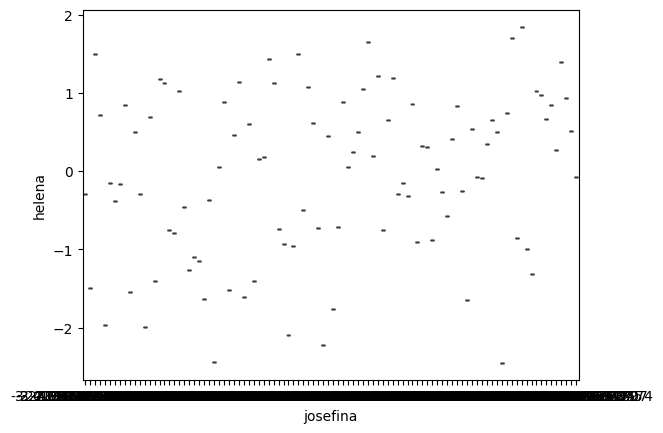

In [16]:
import pandas as pd
import numpy as np

katina = pd.DataFrame({column: np.random.normal(0, 1, 100) for column in ['josefina', 'helena']})
exec(code_clean)   

In [5]:
import pandas as pd
import os

def read_data(file_path):
    """
    Reads data from a CSV or Excel file.
    
    Parameters:
        file_path (str): Path to the file to read.
        
    Returns:
        DataFrame: The data read from the file.
        
    Raises:
        ValueError: If the file format is unsupported.
    """
    if file_path.endswith(".csv"):
        return pd.read_csv(file_path)
    elif file_path.endswith(".xlsx"):
        return pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format.")


def generate_title_and_summary(data, api_key):
    """
    Generates a title, summary, and keywords for a report using ChatGPT.
    
    Parameters:
        data (DataFrame): The data to generate the title and summary for.
        api_key (str): OpenAI API key.
        
    Returns:
        dict: A dictionary containing the title, summary, and keywords.
    """
    # Prepare sample data for prompt by showing the first 5 rows
    sample_data = data.head(5).to_string(index=False)
    
    # Generate title
    title_prompt = f"Generate a title for a report based on the following data:\n{sample_data}"
    title = call_chatgpt(title_prompt, api_key)
    
    # Generate keywords based on the title
    topic_prompt = f"Generate three keywords that describe these data. The first keyword must describe the most important variable in the dataset. Answer exclusively the keywords separated by commas: {title}"
    topic = call_chatgpt(topic_prompt, api_key)
    
    # Generate summary
    summary_prompt = f"Provide a summary of the following data:\n{sample_data}"
    summary = call_chatgpt(summary_prompt, api_key)
    
    return {"title": title, "summary": summary, "topic": topic}


In [6]:

def get_unsplash_image(query, access_key):
    """
    Searches Unsplash for an image based on a query and returns the first image's URL.
    
    Parameters:
        query (str): Search query for the image.
        access_key (str): Unsplash API access key.
    
    Returns:
        str or None: URL of the first image found, or None if no images are found.
    """
    url = f"https://api.unsplash.com/search/photos?query={requests.utils.quote(query)}&client_id={access_key}"
    
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        
        data = response.json()
        if data["results"]:
            return data["results"][0]["urls"]["regular"]
        else:
            return None
    except requests.RequestException as e:
        raise Exception(f"Error in Unsplash request: {e}")

def generate_statistical_questions(data, api_key):
    """
    Generates statistical questions and tests based on the structure of a DataFrame using ChatGPT.
    
    Parameters:
        data (DataFrame): The data to analyze.
        api_key (str): OpenAI API key.
    
    Returns:
        str: The RMarkdown content generated by ChatGPT.
    """
    
    data_info = data.describe()
    
    stat_prompt = (
        "Below is included the info() output of a pandas data frame "
        "I request you to generate 3 statistical questions and tests that can be performed on this data, the dataframe is called data. "
        f" Here is the info() output of the data frame: \n {data_info}"
        " Please provide the questions and the tests that can be performed. If possible include a graph to plot the information. "
        " Your output should be dash components, the output you provide will go into:"
        " 'app.layout = html.Div([ ])'"
        " NO TEXT, only the code for the dash components inside the html.Div([])"
    )
    
    print(data_info)
    
    return call_chatgpt(stat_prompt, api_key)

def generate_report_content(data, api_key, unsplash_access_key):
    """
    Generates report content including title, summary, and image URL.
    
    Parameters:
        data (DataFrame): The data to use for generating content.
        api_key (str): OpenAI API key.
        unsplash_access_key (str): Unsplash API access key.
    
    Returns:
        dict: Contains title, summary, and image URL.
    """
    # Get title and summary
    content_summary = generate_title_and_summary(data, api_key)
    report_title = content_summary["title"]
    report_summary = content_summary["summary"]
    topic = content_summary["topic"]
    
    # Get image URL from Unsplash
    image_url = get_unsplash_image(topic, unsplash_access_key)
    
    return {"title": report_title, "summary": report_summary, "image_url": image_url}

In [7]:
### Params and keys
unsplash_access_key = "" # Replace with your Unsplash access key
api_key = ""     # Replace with your OpenAI API key

In [8]:
# Load the data
file_path = "jamb_exam_results.csv"
df = read_data(file_path)
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [9]:
report_content = generate_report_content(df, api_key, unsplash_access_key)

In [10]:
report_content

{'title': '"Analyzing Factors Influencing JAMB Scores: A Comprehensive Study of Student Performance in Urban and Rural Public Schools"',
 'summary': 'The provided data contains information about five students, focusing on various educational parameters. Here’s a summary of the key points:\n\n1. **JAMB Scores**: The students achieved scores ranging from 182 to 210, indicating a varied performance in the Joint Admissions and Matriculation Board (JAMB) examination.\n\n2. **Study Hours Per Week**: Study hours varied significantly, with one student studying as few as 12 hours per week and another studying up to 29 hours. This suggests differing levels of dedication or external obligations.\n\n3. **Attendance Rate**: Attendance rates are generally high, ranging from 78% to 99%, with all students attending school regularly, which might correlate with their academic performance.\n\n4. **Teacher Quality**: Teacher quality ratings are either 2 or 4 (on an unspecified scale), indicating mixed per

In [11]:
statsReport = generate_statistical_questions(df, api_key)

        JAMB_Score  Study_Hours_Per_Week  Attendance_Rate  Teacher_Quality  \
count  5000.000000           5000.000000      5000.000000      5000.000000   
mean    174.074600             19.521200        84.235200         2.521400   
std      47.616477              9.634569         9.485688         0.985564   
min     100.000000              0.000000        50.000000         1.000000   
25%     135.000000             13.000000        78.000000         2.000000   
50%     170.000000             19.000000        84.000000         2.000000   
75%     209.000000             26.000000        91.000000         3.000000   
max     367.000000             40.000000       100.000000         5.000000   

       Distance_To_School   Student_ID          Age  Assignments_Completed  
count         5000.000000  5000.000000  5000.000000            5000.000000  
mean            10.005460  2500.500000    18.445800               1.804600  
std              4.820221  1443.520003     2.301504               

In [12]:
statsReport

'```python\napp.layout = html.Div([\n    html.H1("Statistical Analysis of Student Data"),\n    \n    html.Div([\n        html.H2("Question 1: Is there a significant correlation between Study Hours Per Week and JAMB Score?"),\n        dcc.Graph(\n            id=\'study_hours_vs_jamb_score\',\n            figure={\n                \'data\': [\n                    {\'x\': data[\'Study_Hours_Per_Week\'], \'y\': data[\'JAMB_Score\'], \'mode\': \'markers\', \'name\': \'Data Points\'},\n                ],\n                \'layout\': {\n                    \'title\': \'Study Hours Per Week vs JAMB Score\',\n                    \'xaxis\': {\'title\': \'Study Hours Per Week\'},\n                    \'yaxis\': {\'title\': \'JAMB Score\'},\n                }\n            }\n        ),\n        html.Button(\'Perform Correlation Test\', id=\'correlation-button\', n_clicks=0),\n        html.Div(id=\'correlation-result\')\n    ]),\n\n    html.Div([\n        html.H2("Question 2: Do Attendance Rate and

In [13]:
def create_dash_app(report_content, image_url, data_summary, stats_report):
    """
    Creates a Dash web application to display report content, images, summaries, and visualizations.

    Parameters:
    - report_content (dict): Contains 'title' for the report title.
    - image_url (str): URL for the image to display.
    - data_summary (str): Summary of the dataset.
    - stats_report (str): Statistical report or visualizations content.
    """
    author_name = "John Doe"
    stats_report = stats_report.replace("```python","").replace("app.layout = html.Div([","").replace("```", "")
    

    dashapp_string = f"""
import dash
from dash import dcc, html
import plotly.express as px
import os
import pandas as pd 

os.chdir('C:/Users/cjrodriguezf/Documents/PhD/IATHON/iathon-template')     

# Load the dataset
data = pd.read_csv('jamb_exam_results.csv')


# Create Dash app layout
app = dash.Dash(__name__)

app.layout = html.Div([
    # Title Section
    html.H1({report_content.get('title', 'Dashboard Report')}, style={{'textAlign': 'center'}}),
    html.H4("Author: {author_name}"),
    
    # Summary Section
    html.H2("Summary of the data"),
    dcc.Markdown(f'''{data_summary}'''),

    # Image Section
    html.Img(src='{image_url}', style={{'maxWidth': '600px', 'height': 'auto'}}),
    
    # Stats Report Section
    html.H2("Statistical Report"),
    
    {stats_report}
    
    

# Run the Dash app
app.run_server(debug=True)
    
    """
    return dashapp_string
    

In [14]:
# save the dash app to a file
dash_app_content = create_dash_app(report_content, report_content["image_url"], report_content["summary"], statsReport)
with open("dash_app.py", "w") as f:
    f.write(dash_app_content)
    
